In [28]:
import pandas as pd
import numpy as np
import gspread
from pydata_google_auth import get_user_credentials
from google.cloud import bigquery
from pycaret.clustering import *

project_id = 'ledger-fcc1e'
creds = get_user_credentials([
    'https://www.googleapis.com/auth/cloud-platform', 
    'https://www.googleapis.com/auth/spreadsheets',
    'https://www.googleapis.com/auth/drive',
])
client = bigquery.Client(project=project_id, credentials=creds)

gc = gspread.authorize(creds) 
pull_data = lambda query: client.query(query).result().to_dataframe()
get_worksheet = lambda key, name: gc.open_by_key(key).worksheet(name)

In [29]:
query =\
'''
-- query for clustering v2
WITH users AS (
  SELECT DISTINCT user_id
  FROM `ledger-fcc1e.dg_buku_trnsfmd.ppm_table`
  WHERE last_transaction_date >= '2023-04-01'
)

, loyalty AS (
  SELECT 
    user_id, 
    date_,
    kyc_tier,
    loyalty_tier,
  FROM `ledger-fcc1e.trb_mxg_reports.loyalty_ssot`
  WHERE 
    date_ >= '2023-04-01'
    AND kyc_tier <> 'NON_KYC'
)

, referrals AS (
  SELECT 
    referrer AS user_id,
    referral_register_date AS ref_date,
    referee
  FROM `ledger-fcc1e.trb_mxg_reports.referral_ssot` 
  WHERE date_ >= '2023-04-01'
)

, profiles AS (
  SELECT DISTINCT
    user_id,
    acquisition_channel,
    user_segment_sub_bucket,
    first_user_date,
    first_any_payment_date,
    first_transaction_date
  FROM `ledger-fcc1e.dg_buku_trnsfmd.user_profile_datamart`
)

, impressions AS (
  SELECT
    SUBSTR(phone_number, 4) AS user_id,
    notification_date AS date_,
    campaign_name,
    SUM(pn_count) AS send_count,
    SUM(impressions_count) AS impressions_count,
    SUM(read_count) AS read_count,
    COUNT(DISTINCT user_activated) AS activated_count,
    COUNT(DISTINCT user_converted) AS converted_count
  FROM `ledger-fcc1e.crm_reports.crm_notification_service_campaign_performance`
  WHERE 
    notification_date BETWEEN '2023-04-01' AND '2023-08-31'
    AND objective_code IN ('PAY_GEN', 'PAY_POUT', 'PPOB_PRE', 'PPOB_GEN', 'PAY', 'PPOB', 'SAL_TOPUP')
  GROUP BY 1, 2, 3
)

, transactions AS (
  SELECT
    user_id,
    transaction_date,
    COUNT(DISTINCT IF(product_type IN ('Payment In', 'Payment Out'), transaction_id, NULL)) AS dcore_count,
    COUNT(DISTINCT IF(product_type IN ('PPOB'), transaction_id, NULL)) AS dppob_count,
    -- CUSTOMER
    COUNT(DISTINCT IF(product_type = 'PPOB', beneficiaryid_ppob, NULL)) + COUNT(DISTINCT IF(product_type = 'Payment Out', destination_bank_account_number, NULL)) AS dtotal_customer,
  FROM `ledger-fcc1e.payment_reports.payments_ssot`
  WHERE
    status_v2 = 'COMPLETED'
    AND transaction_date >= '2023-04-01'
  GROUP BY 1, 2
)

, accountings AS (
  SELECT DISTINCT
    DATE(trans_createdAt) AS acc_date,
    createdByUser AS user_id,
    COUNT(DISTINCT transactionId) AS dacc_count
  FROM `ledger-fcc1e.bukuwarung_analytics.accounting_transactions_table_db`
  WHERE DATE(trans_createdAt) BETWEEN '2023-04-01' AND '2023-07-31'
  GROUP BY 1, 2
)

, temp1 AS (
  SELECT *
  FROM (
    SELECT 
      COALESCE(transactions.user_id, impressions.user_id, accountings.user_id) AS user_id,
      date_,
      campaign_name,
      SUM(dacc_count) AS acc_count,
      SUM(dcore_count) AS core_count,
      SUM(dppob_count) AS ppob_count,
      SUM(dtotal_customer) AS total_customer,
      COUNT(DISTINCT referee) AS ref_count
    FROM impressions
    LEFT JOIN transactions
      ON transactions.user_id = impressions.user_id AND transactions.transaction_date BETWEEN DATE_SUB(impressions.date_, INTERVAL 30 DAY) AND impressions.date_
    LEFT JOIN accountings
      ON accountings.user_id = impressions.user_id AND accountings.acc_date BETWEEN DATE_SUB(impressions.date_, INTERVAL 30 DAY) AND impressions.date_
    LEFT JOIN referrals
      ON referrals.user_id = impressions.user_id AND referrals.ref_date BETWEEN DATE_SUB(impressions.date_, INTERVAL 30 DAY) AND impressions.date_
    GROUP BY 1, 2, 3
  )
  LEFT JOIN impressions USING (user_id, date_, campaign_name)
)



SELECT
  user_id,
  date_,
  campaign_name,
  kyc_tier,
  loyalty_tier,
  acc_count,
  core_count,
  ppob_count,
  total_customer,
  ref_count,
  (CASE WHEN ref_count > 0 THEN 1 ELSE 0 END) AS is_referrer,
  acquisition_channel,
  user_segment_sub_bucket,
  DATE_DIFF(date_, first_user_date, DAY) AS age_on_platform_days,
  CASE WHEN send_count > 0 THEN 1 ELSE IFNULL(send_count, 0) END AS is_send_m1,
  CASE WHEN impressions_count > 0 THEN 1 ELSE IFNULL(impressions_count, 0) END AS is_imp_m1,
  CASE WHEN read_count > 0 THEN 1 ELSE IFNULL(read_count, 0) END AS is_read_m1,
  IFNULL(activated_count, 0) AS is_act_m1,
  IFNULL(converted_count, 0) AS is_conv_m1
FROM users
LEFT JOIN temp1 USING (user_id)
INNER JOIN loyalty USING (user_id, date_)
LEFT JOIN profiles USING (user_id)
WHERE date_ < '2023-09-01'
ORDER BY 1, 2, 3
'''
raw = client.query(query).result().to_dataframe()
raw.to_pickle('data/mes_data_v2.pkl')


raw = pd.read_pickle('data/mes_data_v2.pkl')


In [30]:
# -- QUERY TO GET IMPRESSIONS COUNT
imp_query =\
'''
WITH users AS (
  SELECT DISTINCT user_id
  FROM `ledger-fcc1e.dg_buku_trnsfmd.ppm_table`
  WHERE last_transaction_date >= '2023-04-01'
)

, loyalty AS (
  SELECT user_id, date_
  FROM `ledger-fcc1e.trb_mxg_reports.loyalty_ssot`
  WHERE 
    date_ >= '2023-04-01'
    AND kyc_tier <> 'NON_KYC'
)

, impressions AS (
  SELECT
    SUBSTR(phone_number, 4) AS user_id,
    notification_date AS date_,
    campaign_name,
    SUM(pn_count) AS send_count,
    SUM(impressions_count) AS impressions_count,
    SUM(read_count) AS read_count,
    COUNT(DISTINCT user_activated) AS activated_count,
    COUNT(DISTINCT user_converted) AS converted_count
  FROM `ledger-fcc1e.crm_reports.crm_notification_service_campaign_performance`
  WHERE 
    notification_date BETWEEN '2023-05-01' AND '2023-08-31'
    AND objective_code IN ('PAY_GEN', 'PAY_POUT', 'PPOB_PRE', 'PPOB_GEN', 'PAY', 'PPOB', 'SAL_TOPUP')
  GROUP BY 1, 2, 3
)

SELECT
  user_id,
  date_,
  campaign_name,
  CASE WHEN send_count > 0 THEN 1 ELSE IFNULL(send_count, 0) END AS send_count,
  CASE WHEN impressions_count > 0 THEN 1 ELSE IFNULL(impressions_count, 0) END AS impressions_count,
  CASE WHEN read_count > 0 THEN 1 ELSE IFNULL(read_count, 0) END AS read_count,
  IFNULL(activated_count, 0) AS activated_count,
  IFNULL(converted_count, 0) AS converted_count
FROM users
LEFT JOIN impressions USING (user_id)
INNER JOIN loyalty USING (user_id, date_)
WHERE send_count IS NOT NULL
'''
imp = client.query(imp_query).result().to_dataframe()
imp.to_pickle('data/mes_imp_v2.pkl')


imp = pd.read_pickle('data/mes_imp_v2.pkl')

In [31]:
raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 516280 entries, 0 to 516279
Data columns (total 19 columns):
 #   Column                   Non-Null Count   Dtype 
---  ------                   --------------   ----- 
 0   user_id                  516280 non-null  object
 1   date_                    516280 non-null  dbdate
 2   campaign_name            516280 non-null  object
 3   kyc_tier                 516280 non-null  object
 4   loyalty_tier             516280 non-null  object
 5   acc_count                90522 non-null   Int64 
 6   core_count               462628 non-null  Int64 
 7   ppob_count               462628 non-null  Int64 
 8   total_customer           462628 non-null  Int64 
 9   ref_count                516280 non-null  Int64 
 10  is_referrer              516280 non-null  Int64 
 11  acquisition_channel      516280 non-null  object
 12  user_segment_sub_bucket  516280 non-null  object
 13  age_on_platform_days     516280 non-null  Int64 
 14  is_send_m1          

In [32]:
df =\
(
    raw
    .assign(
        # referee_count = lambda x: x.referee_count.fillna(0),
        date_ = lambda x: x.date_.astype(str),
        index_ = lambda x: x.user_id + "/" + x.date_ + "/" + x.campaign_name,

        # M1_core_count = lambda x: x.M1_core_count/std_core,
        # M1_acc_count = lambda x: x.M1_acc_count/std_acc,
        # M1_ppob_count = lambda x: x.M1_ppob_count/std_ppob,
        # M1_campaign_saldo = lambda x: x.M1_campaign_saldo/std_saldo,
        # age_on_platform_days = lambda x: x.age_on_platform_days/std_age,
        core_count = lambda x: np.log1p(x.core_count),
        ppob_count = lambda x: np.log1p(x.ppob_count),
        acc_count = lambda x: np.log1p(x.acc_count),
        #M1_campaign_saldo = lambda x: np.log1p(x.M1_campaign_saldo),
        age_on_platform_days = lambda x: np.log1p(x.age_on_platform_days),

        is_send_m1 = lambda x: x.is_send_m1.fillna(0),
        is_imp_m1 = lambda x: x.is_imp_m1.fillna(0),
        is_read_m1 = lambda x: x.is_read_m1.fillna(0),
        is_act_m1 = lambda x: x.is_act_m1.fillna(0),
        is_conv_m1 = lambda x: x.is_conv_m1.fillna(0),
    )
    .drop(columns=['user_id', 'date_', 'is_send_m1', 'is_imp_m1', 'is_read_m1', 'is_act_m1', 'is_conv_m1'])
    # .drop(columns=['user_id', 'date_', 'M1_core_count', 'M1_acc_count', 'M1_ppob_count'])
    # .drop(columns=['user_id', 'date_'])
    .set_index('index_')
)
df

,campaign_name,kyc_tier,loyalty_tier,acc_count,core_count,ppob_count,total_customer,ref_count,is_referrer,acquisition_channel,user_segment_sub_bucket,age_on_platform_days
index_,,,,,,,,,,,,
8111081132/2023-06-16/SAL_TOPUP_ADP_CRM_O_TXT_WA_A5_M6_E5_160623_10_SALDO TACTICAL - ADOPTION - COHORT 2,SAL_TOPUP_ADP_CRM_O_TXT_WA_A5_M6_E5_160623_10_...,ADVANCED,Bronze,5.204007,<NA>,<NA>,<NA>,0,0,Organic Acquisition,traderO2O-PAonly,3.433987
8111081132/2023-08-17/PAY_GEN_INF_CRM_O_ITX_PN_A3_M6_E1_170823_09_PAYDAY PROMO - ALL ELIGIBLE USERS - LAUCH DAY,PAY_GEN_INF_CRM_O_ITX_PN_A3_M6_E1_170823_09_PA...,ADVANCED,Bronze,3.850148,0.0,3.044522,20,0,0,Organic Acquisition,traderO2O-PAonly,4.532599
8111081132/2023-08-23/PPOB_GEN_ADP_CRM_O_ITX_WA_A5_M6_E5_230823_16_ALL ADVANCE - PPOB,PPOB_GEN_ADP_CRM_O_ITX_WA_A5_M6_E5_230823_16_A...,ADVANCED,Bronze,3.332205,0.0,2.564949,12,0,0,Organic Acquisition,traderO2O-PAonly,4.59512
8111100602/2023-07-26/PAY_GEN_RTN_CRM_O_TXT_WA_A2_M6_E5_260723_17_BUKUXP PERSONALIZED CAMPAIGN Q3 - USERS WITH 0 BUKUXP - BRONZE,PAY_GEN_RTN_CRM_O_TXT_WA_A2_M6_E5_260723_17_BU...,SUPREME,Bronze,<NA>,<NA>,<NA>,<NA>,0,0,Offline Acquisition,traderO2O-PPonly,6.388561
8111108557/2023-06-16/SAL_TOPUP_ADP_CRM_O_TXT_WA_A5_M6_E5_160623_10_SALDO TACTICAL - ADOPTION - COHORT 2,SAL_TOPUP_ADP_CRM_O_TXT_WA_A5_M6_E5_160623_10_...,ADVANCED,Bronze,5.56452,<NA>,<NA>,<NA>,0,0,Organic Acquisition,puretrader-F&B,3.496508
...,...,...,...,...,...,...,...,...,...,...,...,...
8999999557/2023-08-21/PAY_GEN_RTN_CRM_O_TXT_WA_A2_M6_E5_210823_07_DOUBLE BUKUXP DAY - NON PERSONALIZED THANK YOU USERS,PAY_GEN_RTN_CRM_O_TXT_WA_A2_M6_E5_210823_07_DO...,SUPREME,Diamond,<NA>,6.487684,0.693147,504,0,0,Offline Acquisition,pureO2O-PAonly,6.36647
8999999557/2023-08-22/PAY_GEN_RTN_CRM_O_TXT_WA_A2_M6_E5_210823_07_DOUBLE BUKUXP DAY - NON PERSONALIZED THANK YOU USERS,PAY_GEN_RTN_CRM_O_TXT_WA_A2_M6_E5_210823_07_DO...,SUPREME,Diamond,<NA>,6.481577,0.693147,500,0,0,Offline Acquisition,pureO2O-PAonly,6.368187
8999999557/2023-08-28/PAY_GEN_RTN_CRM_O_TXT_WA_A2_M6_E5_280823_18_DOUBLE BUKUXP DAY - PRE COMMS DAY-2,PAY_GEN_RTN_CRM_O_TXT_WA_A2_M6_E5_280823_18_DO...,SUPREME,Diamond,<NA>,6.47851,0.693147,502,0,0,Offline Acquisition,pureO2O-PAonly,6.378426


In [33]:
df.describe()

,acc_count,core_count,ppob_count,total_customer,ref_count,is_referrer,age_on_platform_days
count,90522.0,462628.0,462628.0,462628.0,516280.0,516280.0,516280.0
mean,4.887781,2.218997,2.634374,1684.362099,0.019546,0.013855,5.260544
std,2.490344,2.162235,2.292327,80339.510275,0.214823,0.116889,1.452523
min,0.693147,0.0,0.0,0.0,0.0,0.0,0.0
25%,3.135494,0.0,0.0,6.0,0.0,0.0,4.442651
50%,4.663439,1.609438,2.484907,40.0,0.0,0.0,5.57973
75%,6.659294,3.931826,4.330733,136.0,0.0,0.0,6.437752
max,16.552716,17.27025,15.001931,29984256.0,23.0,1.0,7.277939


In [34]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 516280 entries, 8111081132/2023-06-16/SAL_TOPUP_ADP_CRM_O_TXT_WA_A5_M6_E5_160623_10_SALDO TACTICAL - ADOPTION - COHORT 2 to 8999999557/2023-08-30/PAY_GEN_RTN_CRM_O_TXT_WA_A2_M6_E5_300823_07_DOUBLE BUKUXP DAY - LAUNCH COMMS FOR BRONZE-DIAMOND USERS
Data columns (total 12 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   campaign_name            516280 non-null  object 
 1   kyc_tier                 516280 non-null  object 
 2   loyalty_tier             516280 non-null  object 
 3   acc_count                90522 non-null   Float64
 4   core_count               462628 non-null  Float64
 5   ppob_count               462628 non-null  Float64
 6   total_customer           462628 non-null  Int64  
 7   ref_count                516280 non-null  Int64  
 8   is_referrer              516280 non-null  Int64  
 9   acquisition_channel      516280 non-null  object 
 10  user_segm

In [35]:
s = setup(
    df, 
    normalize=True, 
    ignore_features=['user_id', 'campaign_name'],
    use_gpu = True,
    session_id = 123,
    index=True)

,Description,Value
0,Session id,123
1,Original data shape,"(516280, 12)"
2,Transformed data shape,"(516280, 28)"
3,Ignore features,2
4,Ordinal features,1
5,Numeric features,7
6,Categorical features,4
7,Rows with missing values,84.8%
8,Preprocess,True
9,Imputation type,simple


In [36]:
kmeans = create_model('kmeans', num_clusters=6)

In [37]:
# plot_model(kmeans, 'tsne')

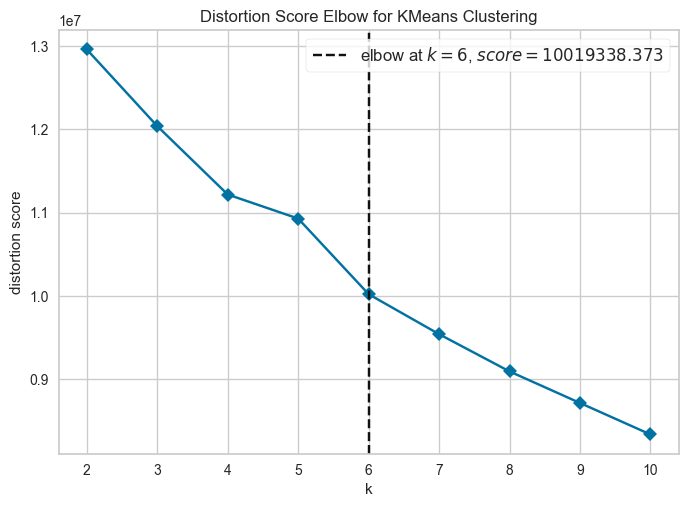

In [38]:
plot_model(kmeans, plot = 'elbow')

In [39]:
# plot_model(kmeans, plot = 'distribution')

In [40]:
imp_df =\
(
    imp
    .assign(
        date_ = lambda x: x.date_.astype(str)
    )
)

In [41]:
imp_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 473538 entries, 0 to 473537
Data columns (total 8 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   user_id            473538 non-null  object
 1   date_              473538 non-null  object
 2   campaign_name      473538 non-null  object
 3   send_count         473538 non-null  Int64 
 4   impressions_count  473538 non-null  Int64 
 5   read_count         473538 non-null  Int64 
 6   activated_count    473538 non-null  Int64 
 7   converted_count    473538 non-null  Int64 
dtypes: Int64(5), object(3)
memory usage: 31.2+ MB


In [42]:
imp_df.describe()

,send_count,impressions_count,read_count,activated_count,converted_count
count,473538.0,473538.0,473538.0,473538.0,473538.0
mean,1.0,0.822663,0.635738,0.298947,0.143131
std,0.0,0.381954,0.481223,0.457797,0.350207
min,1.0,0.0,0.0,0.0,0.0
25%,1.0,1.0,0.0,0.0,0.0
50%,1.0,1.0,1.0,0.0,0.0
75%,1.0,1.0,1.0,1.0,0.0
max,1.0,1.0,1.0,1.0,1.0


In [61]:
res =\
(
    assign_model(kmeans)
    .reset_index()
    .assign(
        user_id = lambda x: x.index_.str.split("/", expand=False).str[0],
        date_ = lambda x: x.index_.str.split("/", expand=False).str[1],
        campaign_name_index = lambda x: x.index_.str.split("/", expand=False).str[2]
    )
    .drop(columns=['index_'])
    .merge(imp_df, how='right', on=['user_id', 'date_'])
    # .assign(
    #     impressions_count = lambda x: x.impressions_count.fillna(0),
    #     read_count = lambda x: x.read_count.fillna(0),
    # )
)

In [62]:
res

,kyc_tier,loyalty_tier,acc_count,core_count,ppob_count,total_customer,ref_count,is_referrer,acquisition_channel,user_segment_sub_bucket,...,Cluster,user_id,date_,campaign_name_index,campaign_name,send_count,impressions_count,read_count,activated_count,converted_count
0,SUPREME,Gold,<NA>,3.367296,2.70805,33,0,0,Paid Acquisition,traderO2O-PA+PP,...,Cluster 3,83816966432,2023-08-31,PAY_GEN_RTN_CRM_O_TXT_WA_A2_M6_E5_280823_18_DO...,PAY_GEN_RTN_CRM_O_TXT_WA_A2_M6_E5_290823_17_DO...,1,0,1,0,0
1,SUPREME,Gold,<NA>,3.367296,2.70805,33,0,0,Paid Acquisition,traderO2O-PA+PP,...,Cluster 3,83816966432,2023-08-31,PAY_GEN_RTN_CRM_O_TXT_WA_A2_M6_E5_290823_17_DO...,PAY_GEN_RTN_CRM_O_TXT_WA_A2_M6_E5_290823_17_DO...,1,0,1,0,0
2,SUPREME,Gold,<NA>,3.367296,2.70805,33,0,0,Paid Acquisition,traderO2O-PA+PP,...,Cluster 3,83816966432,2023-08-31,PAY_GEN_RTN_CRM_O_TXT_WA_A2_M6_E5_300823_07_DO...,PAY_GEN_RTN_CRM_O_TXT_WA_A2_M6_E5_290823_17_DO...,1,0,1,0,0
3,SUPREME,Gold,<NA>,3.367296,2.70805,33,0,0,Paid Acquisition,traderO2O-PA+PP,...,Cluster 3,83816966432,2023-08-31,PAY_GEN_RTN_CRM_O_TXT_WA_A2_M6_E5_280823_18_DO...,PAY_GEN_RTN_CRM_O_TXT_WA_A2_M6_E5_300823_07_DO...,1,0,1,0,0
4,SUPREME,Gold,<NA>,3.367296,2.70805,33,0,0,Paid Acquisition,traderO2O-PA+PP,...,Cluster 3,83816966432,2023-08-31,PAY_GEN_RTN_CRM_O_TXT_WA_A2_M6_E5_290823_17_DO...,PAY_GEN_RTN_CRM_O_TXT_WA_A2_M6_E5_300823_07_DO...,1,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
583879,SUPREME,Bronze,0.693147,0.693147,0.0,1,0,0,Offline Acquisition,pureO2O-PPonly,...,Cluster 0,85648412424,2023-06-03,PAY_POUT_ADP_CRM_F_TXT_WA_A5_M6_E5_030523_00_N...,PAY_POUT_ADP_CRM_F_TXT_WA_A5_M6_E5_030523_00_N...,1,1,1,0,0
583880,SUPREME,Bronze,<NA>,0.693147,2.197225,6,0,0,Offline Acquisition,puretrader-FMCG,...,Cluster 0,85335058247,2023-06-03,PAY_POUT_ADP_CRM_F_TXT_WA_A5_M6_E5_030523_00_N...,PAY_POUT_ADP_CRM_F_TXT_WA_A5_M6_E5_030523_00_N...,1,1,1,0,0
583881,ADVANCED,Bronze,3.496508,<NA>,<NA>,<NA>,0,0,Offline Acquisition,pureO2O-PAonly,...,Cluster 0,85234324944,2023-06-03,PAY_GEN_INF_CRM_F_TXT_WA_A3_M6_E1_020623_16_AD...,PAY_GEN_INF_CRM_F_TXT_WA_A3_M6_E1_020623_16_AD...,1,1,0,0,0
583882,SUPREME,Bronze,<NA>,0.693147,0.0,1,0,0,Offline Acquisition,pureO2O-PAonly,...,Cluster 0,85269723405,2023-06-03,PAY_POUT_ADP_CRM_F_TXT_WA_A5_M6_E5_030523_00_N...,PAY_POUT_ADP_CRM_F_TXT_WA_A5_M6_E5_030523_00_N...,1,1,1,0,0


In [68]:
res.groupby(['Cluster']).agg('mean')

,acc_count,core_count,ppob_count,total_customer,ref_count,is_referrer,age_on_platform_days,send_count,impressions_count,read_count,activated_count,converted_count
Cluster,,,,,,,,,,,,
Cluster 0,3.311368,1.321169,1.399775,22.323875,0.0,0.0,4.559568,1.0,0.805539,0.663908,0.135436,0.044566
Cluster 1,10.511436,7.853698,8.439652,100208.05606,1.342847,1.0,5.614676,1.0,0.788536,0.755539,0.422447,0.220014
Cluster 2,5.338277,2.816871,2.505024,111.428782,0.0,0.0,5.623695,1.0,0.740438,0.692974,0.299884,0.124156
Cluster 3,5.518959,1.564672,3.086406,273.182168,0.0,0.0,6.347049,1.0,0.810145,0.672289,0.291468,0.12531
Cluster 4,5.845921,4.276856,3.515478,410.6225,0.0,0.0,5.834749,1.0,0.708157,0.735131,0.459714,0.292859
Cluster 5,5.204692,0.162525,3.488329,233.978551,0.0,0.0,5.278682,1.0,0.834102,0.668453,0.248953,0.067194


In [64]:
res.groupby([ 'date_', 'Cluster']).agg('count')

kyc_tier  loyalty_tier  acc_count  core_count  \
date_      Cluster                                                    
2023-05-01 Cluster 0       133           133         13         121   
           Cluster 1         2             2          0           2   
           Cluster 2         6             6          1           5   
           Cluster 3         5             5          3           3   
           Cluster 4         7             7          0           6   
...                        ...           ...        ...         ...   
2023-08-31 Cluster 1         9             9          0           9   
           Cluster 2       420           420          0         387   
           Cluster 3        81            81          0          81   
           Cluster 4       606           606          0         595   
           Cluster 5         1             1          0           1   

                      ppob_count  total_customer  ref_count  is_referrer  \
date_      Cluster                                                         
2023-05-01 Cluster 0         121             121        133          133   
           Cluster 1           2               2          2            2   
           Cluster 2           5               5          6            6   
           Cluster 3           3               3          5            5   
           Cluster 4           6               6          7            7   
...                          ...             ...        ...          ...   
2023-08-31 Cluster 1           9               9          9            9   
           Cluster 2         387             387        420          420   
           Cluster 3          81              81         81           81   
           Cluster 4         595             595        606          606   
           Cluster 5           1               1          1            1   

                      acquisition_channel  user_segment_sub_bucket  \
date_      Cluster                                                   
2023-05-01 Cluster 0                  133                      133   
           Cluster 1                    2                        2   
           Cluster 2                    6                        6   
           Cluster 3                    5                        5   
           Cluster 4                    7                        7   
...                                   ...                      ...   
2023-08-31 Cluster 1                    9                        9   
           Cluster 2                  420                      420   
           Cluster 3                   81                       81   
           Cluster 4                  606                      606   
           Cluster 5                    1                        1   

                      age_on_platform_days  user_id  campaign_name_index  \
date_      Cluster                                                         
2023-05-01 Cluster 0                   133      133                  133   
           Cluster 1                     2        2                    2   
           Cluster 2                     6        6                    6   
           Cluster 3                     5        5                    5   
           Cluster 4                     7        7                    7   
...                                    ...      ...                  ...   
2023-08-31 Cluster 1                     9        9                    9   
           Cluster 2                   420      420                  420   
           Cluster 3                    81       81                   81   
           Cluster 4                   606      606                  606   
           Cluster 5                     1        1                    1   

                      campaign_name  send_count  impressions_count  \
date_      Cluster                                                   
2023-05-01 Cluster 0            133         133                133   

In [65]:
save_model(kmeans, "model3")

Transformation Pipeline and Model Successfully Saved


(Pipeline(memory=FastMemory(location=C:\Users\bukuw\AppData\Local\Temp\joblib),
          steps=[('numerical_imputer',
                  TransformerWrapper(include=['acc_count', 'core_count',
                                              'ppob_count', 'total_customer',
                                              'ref_count', 'is_referrer',
                                              'age_on_platform_days'],
                                     transformer=SimpleImputer())),
                 ('categorical_imputer',
                  TransformerWrapper(include=['kyc_tier', 'loyalty_tier',
                                              'acq...
                  TransformerWrapper(include=['loyalty_tier',
                                              'acquisition_channel',
                                              'user_segment_sub_bucket'],
                                     transformer=OneHotEncoder(cols=['loyalty_tier',
                                                          

In [66]:
# res.to_csv('result/result_v3.csv')